<a href="https://colab.research.google.com/github/carloscotrini/transformers_from_scratch/blob/main/AML_MyTransfomerV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random

SHAPES = ["triangle", "circle"]
PLURALS = [shape + "s" for shape in SHAPES]
ARTICLES = ["a", "one"]
TWO_ARTICLES = ["two"]
CONNECTORS = ["and", "then"]
REVERSE_CONNECTORS = ["after"]
CLASS_TOKEN = "CLS"
MASK_TOKEN = "MASK"
SEP_TOKEN = "SEP"
PAD_TOKEN = "PAD"
SPECIAL_TOKENS = [CLASS_TOKEN, MASK_TOKEN, SEP_TOKEN, PAD_TOKEN]
VOCABULARY = SHAPES + PLURALS + ARTICLES + CONNECTORS + REVERSE_CONNECTORS + TWO_ARTICLES + SPECIAL_TOKENS
MAX_LEN_SENTENCE = 16 # Maximum possible length of a sequence

def generate_descr_from_list(r):
  if len(r) > 4:
    raise Exception("Too many items")
  elif len(r) == 0:
    return ""
  elif len(r) == 1:
    article = random.choice(ARTICLES)
    return "{} {}".format(article, r[0])
  else:
    reversed_descr = random.random() > 0.5
    if reversed_descr:
      descr = "{} {} {}".format(r[1], random.choice(REVERSE_CONNECTORS), r[0])
      if len(r) > 2:
        return descr + " " + random.choice(CONNECTORS) + " " + generate_descr_from_list(r[2:])
      return descr
    if r[0] == r[1]:
      plural_desc = random.random() > 0.5
      if plural_desc:
          return "{} {}s".format(random.choice(TWO_ARTICLES), r[0])
    return generate_descr_from_list([r[0]]) + " " + random.choice(CONNECTORS) + " " + generate_descr_from_list(r[1:])


def generate_random_shapes():
  num_shapes = random.randint(1, 4)
  result = []
  for _ in range(num_shapes):
    result.append(random.choice(SHAPES))
  return result


for i in range(100):
  print(generate_descr_from_list(generate_random_shapes()))



a triangle and two circles
circle after triangle and one triangle
a circle then one triangle and circle after circle
one triangle
circle after triangle then one triangle
a circle and two triangles
triangle after circle and one circle and a triangle
triangle after circle
triangle after circle
circle after triangle then one triangle
a triangle
triangle after circle
circle after circle then one triangle
circle after circle then triangle after triangle
one triangle and circle after triangle then one circle
one triangle and one triangle
a circle
circle after circle
triangle after triangle and one circle
triangle after triangle and triangle after triangle
triangle after circle then circle after circle
triangle after triangle then one circle then one circle
one circle
triangle after triangle
one circle then triangle after triangle then a triangle
triangle after circle and one circle
a triangle
a circle
a circle
one triangle then triangle after circle
triangle after triangle
one circle
circle 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

def generate_image(word_list, filename):
    # Create a blank 32x32 image
    image_size = 32
    patch_size = 16
    image = Image.new("1", (image_size, image_size), 1)  # '1' for 1-bit pixels, black and white

    for i, word in enumerate(word_list):
        if word not in ["triangle", "circle"]:
            continue

        # Determine the top-left corner of the patch
        x_offset = (i % 2) * patch_size
        y_offset = (i // 2) * patch_size

        # Draw the shape in the corresponding patch
        draw = ImageDraw.Draw(image)
        if word == "triangle":
            points = [(random.randint(x_offset, x_offset + patch_size), random.randint(y_offset, y_offset + patch_size)) for _ in range(3)]
            draw.polygon(points, fill=0)
        elif word == "circle":
            radius = random.randint(2, patch_size // 2)
            center_x = random.randint(x_offset + radius, x_offset + patch_size - radius)
            center_y = random.randint(y_offset + radius, y_offset + patch_size - radius)
            draw.ellipse([center_x - radius, center_y - radius, center_x + radius, center_y + radius], fill=0)

    # Save the image to the specified filename
    image.save(filename)

def plot_image(filename):
    # Open the image
    image = Image.open(filename)

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example usage:
generate_image(["circle", "triangle", "circle"], "output_image.png")


In [3]:
NUMBER_CODES = [str(i) for i in range(5)]
SHAPE_CODES = [shape[0] for shape in SHAPES]
CODES = NUMBER_CODES + SHAPE_CODES
CODE_VOCABULARY = SPECIAL_TOKENS + CODES

def generate_code_str(shape_list):
  codes = []
  i = 0
  while i < len(shape_list):
    j = i + 1
    while j < len(shape_list) and shape_list[i] == shape_list[j]:
      j += 1
    codes.append(f"{NUMBER_CODES[j-i]} {shape_list[i][0]}")
    i = j
  return " ".join(codes)

['circle']
a circle
1 c


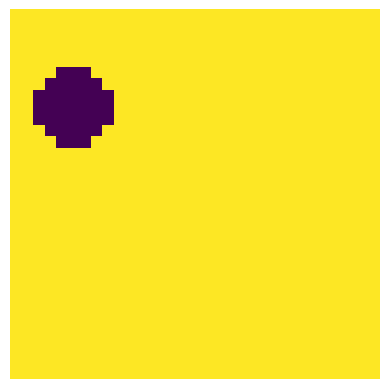

['circle', 'triangle']
a circle and a triangle
1 c 1 t


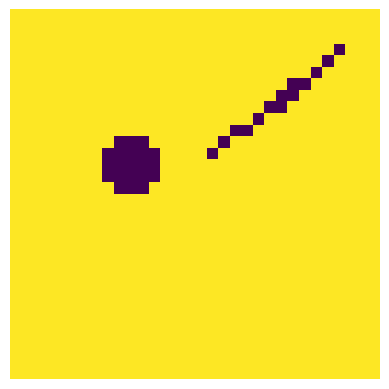

['circle']
a circle
1 c


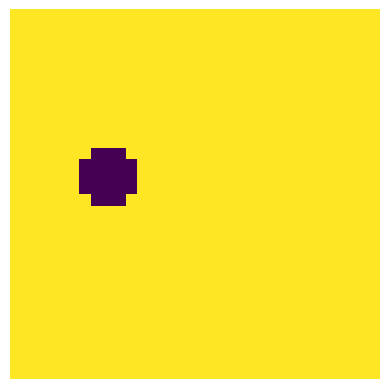

['triangle']
one triangle
1 t


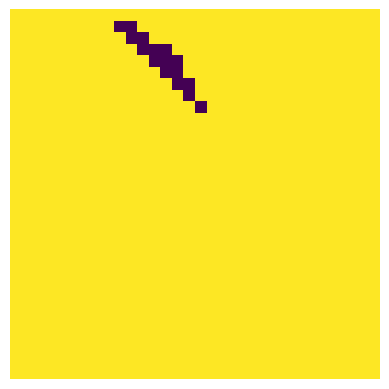

['circle']
one circle
1 c


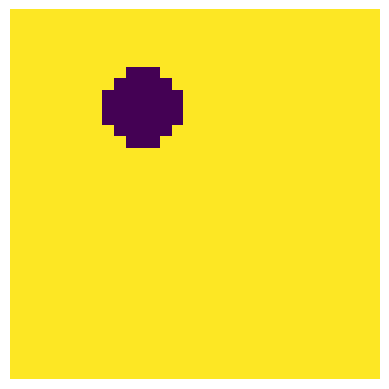

['circle', 'triangle', 'circle']
one circle and circle after triangle
1 c 1 t 1 c


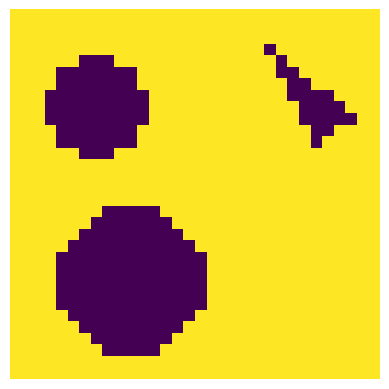

['triangle', 'triangle', 'triangle']
two triangles
3 t


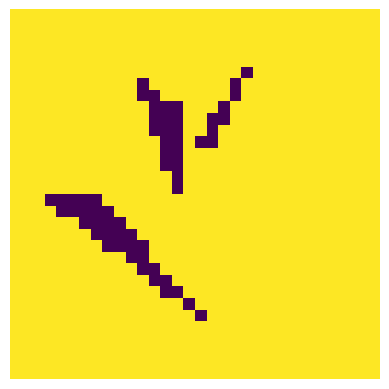

['circle', 'circle']
a circle and a circle
2 c


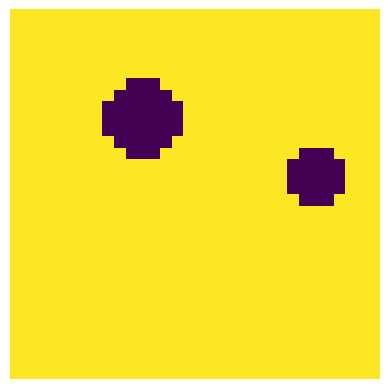

['triangle']
one triangle
1 t


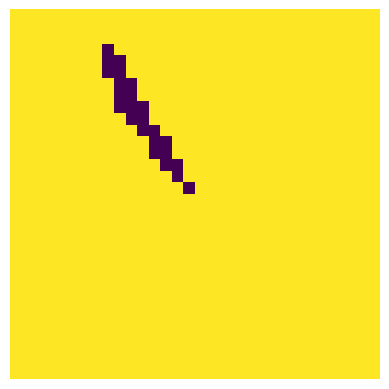

['circle', 'circle', 'triangle']
circle after circle then one triangle
2 c 1 t


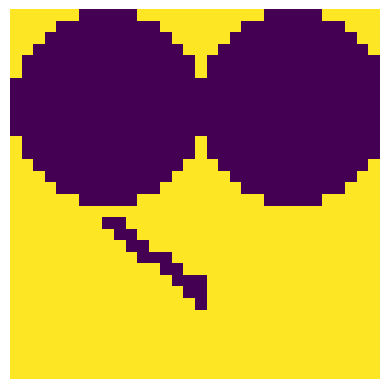

['triangle']
one triangle
1 t


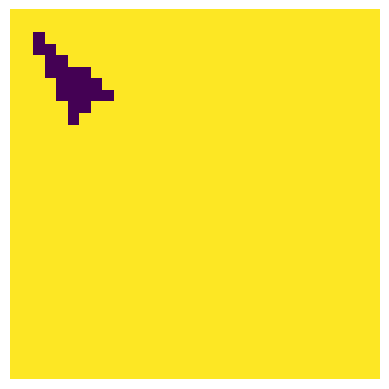

['circle', 'triangle']
a circle and one triangle
1 c 1 t


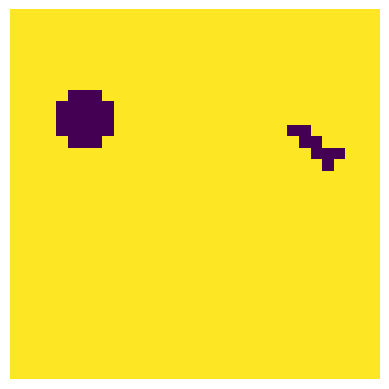

['triangle', 'triangle']
a triangle and a triangle
2 t


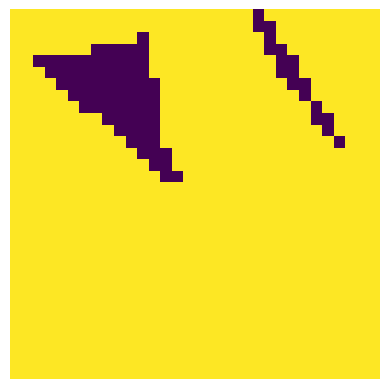

['circle', 'circle', 'circle', 'circle']
a circle then circle after circle then one circle
4 c


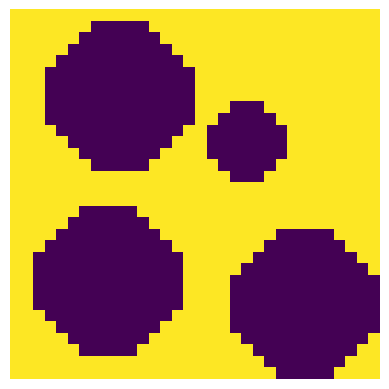

['triangle', 'circle', 'triangle']
circle after triangle and a triangle
1 t 1 c 1 t


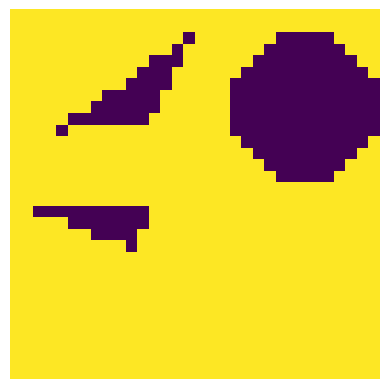

['triangle', 'triangle']
triangle after triangle
2 t


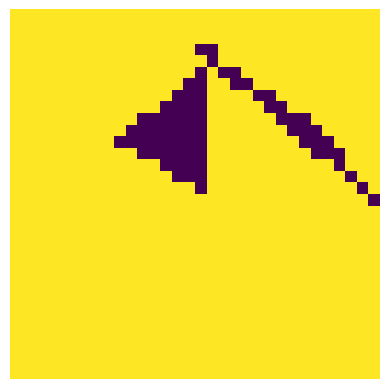

['triangle', 'triangle']
two triangles
2 t


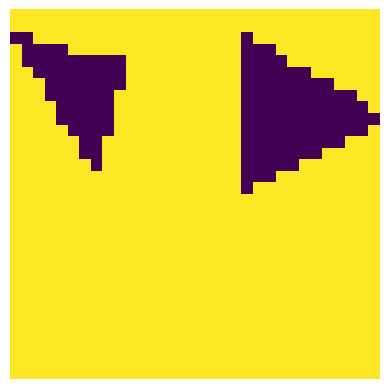

['circle', 'circle', 'circle']
one circle then two circles
3 c


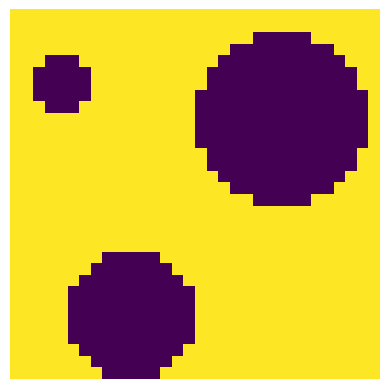

['triangle', 'circle', 'circle']
circle after triangle and one circle
1 t 2 c


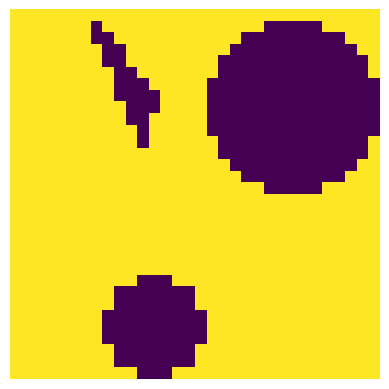

['circle', 'triangle', 'triangle']
a circle and two triangles
1 c 2 t


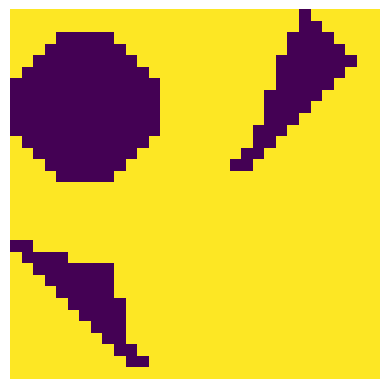

['triangle', 'circle', 'circle']
a triangle and circle after circle
1 t 2 c


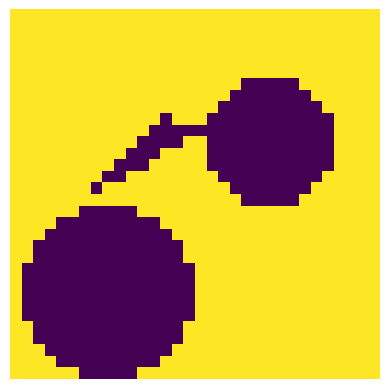

['triangle', 'triangle', 'triangle', 'circle']
a triangle and one triangle then a triangle and one circle
3 t 1 c


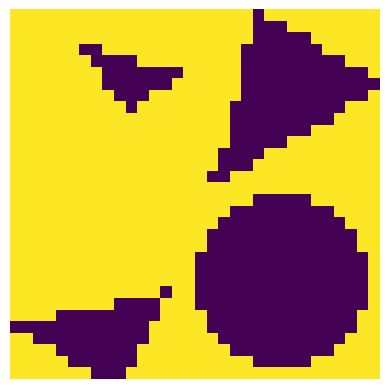

['triangle']
one triangle
1 t


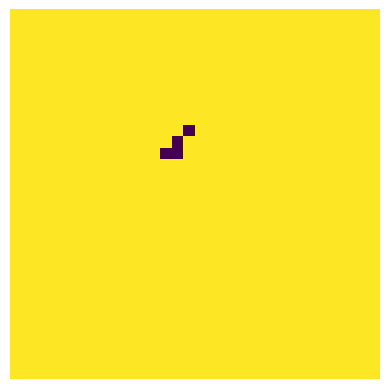

['circle', 'triangle']
triangle after circle
1 c 1 t


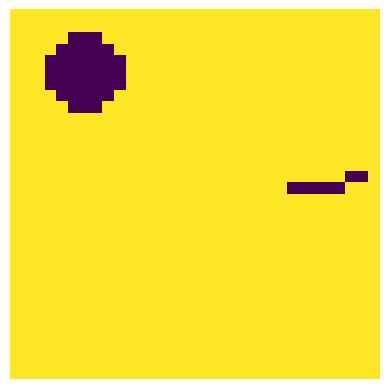

['circle']
a circle
1 c


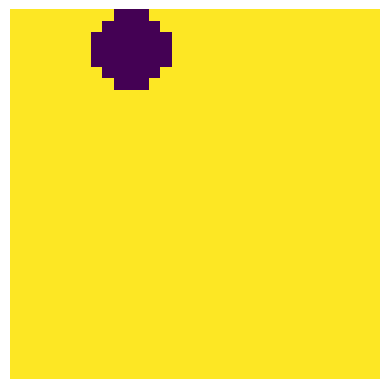

['triangle', 'circle', 'triangle']
circle after triangle then a triangle
1 t 1 c 1 t


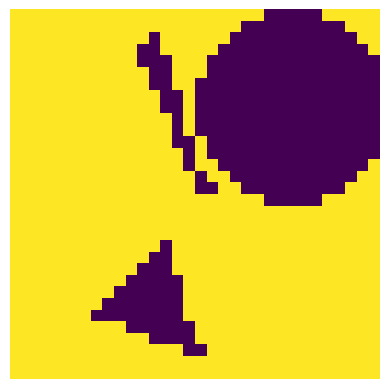

['circle', 'circle', 'triangle', 'triangle']
one circle then a circle then triangle after triangle
2 c 2 t


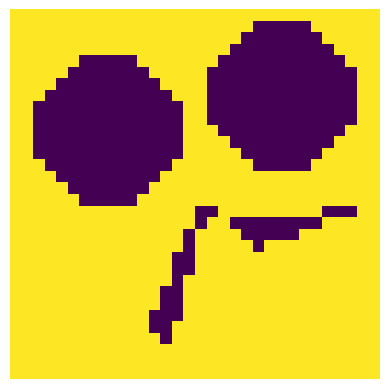

['triangle']
one triangle
1 t


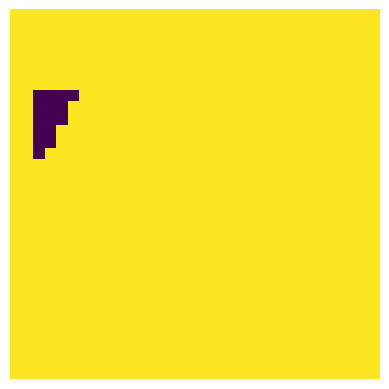

['triangle', 'triangle', 'circle']
two triangles
2 t 1 c


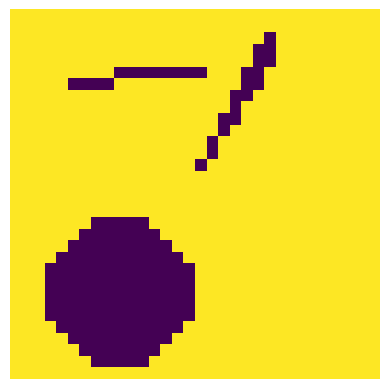

['triangle']
a triangle
1 t


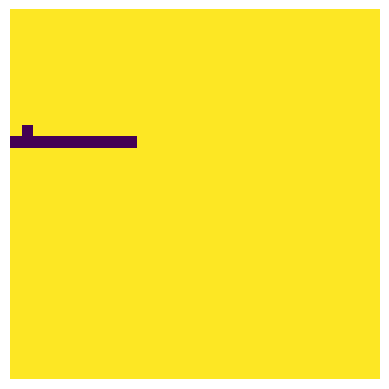

['circle', 'circle', 'circle', 'triangle']
a circle and two circles
3 c 1 t


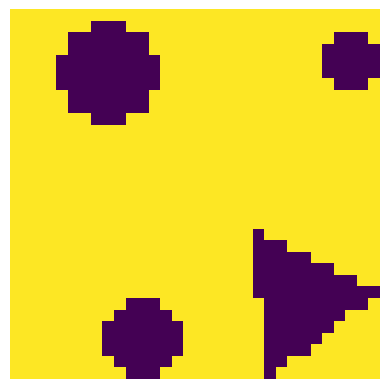

['circle', 'triangle']
one circle then a triangle
1 c 1 t


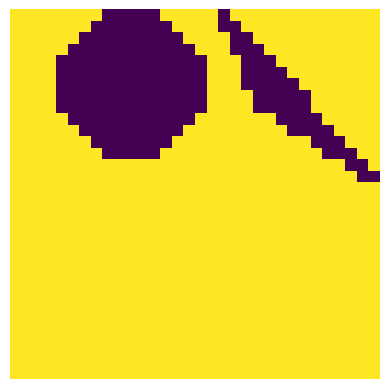

['circle']
a circle
1 c


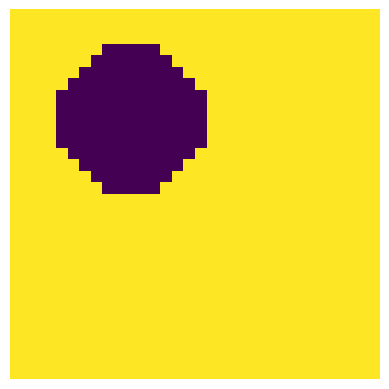

['circle', 'triangle', 'circle']
triangle after circle then one circle
1 c 1 t 1 c


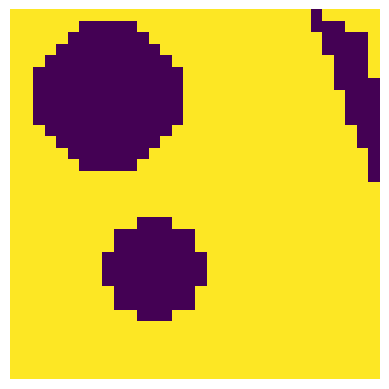

['triangle']
one triangle
1 t


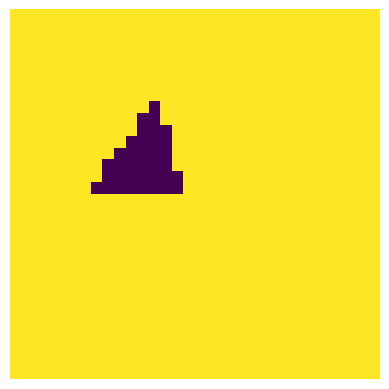

['triangle']
one triangle
1 t


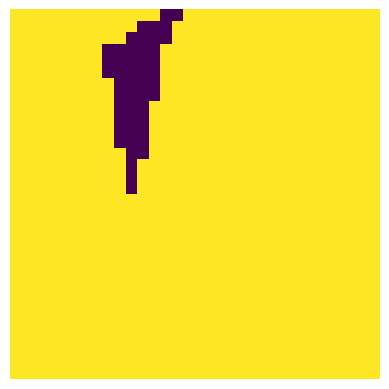

['triangle']
one triangle
1 t


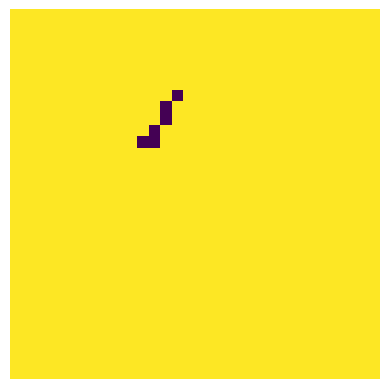

['triangle']
a triangle
1 t


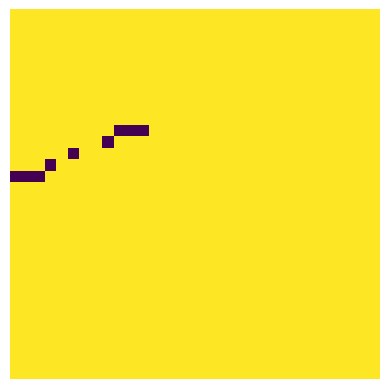

['circle']
a circle
1 c


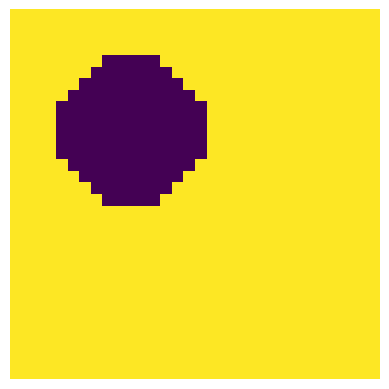

['triangle', 'triangle', 'triangle']
triangle after triangle and one triangle
3 t


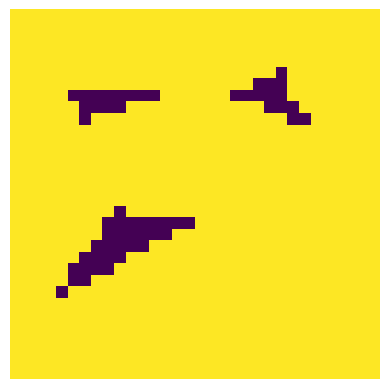

['circle', 'circle']
circle after circle
2 c


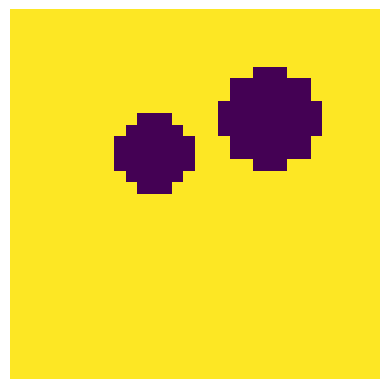

['triangle', 'circle', 'triangle', 'triangle']
circle after triangle then triangle after triangle
1 t 1 c 2 t


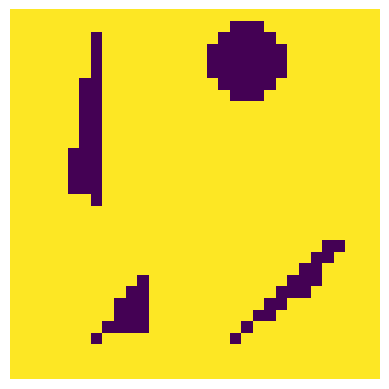

['circle']
a circle
1 c


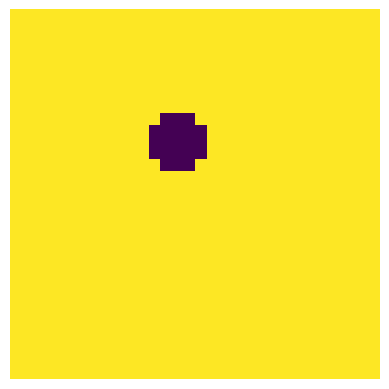

['triangle', 'triangle', 'circle', 'triangle']
triangle after triangle and triangle after circle
2 t 1 c 1 t


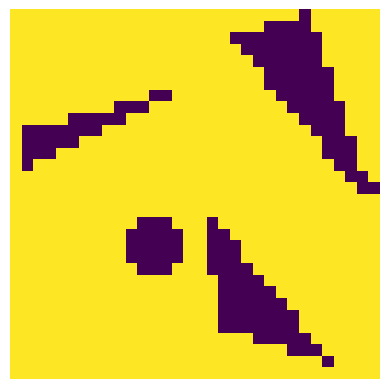

['triangle']
a triangle
1 t


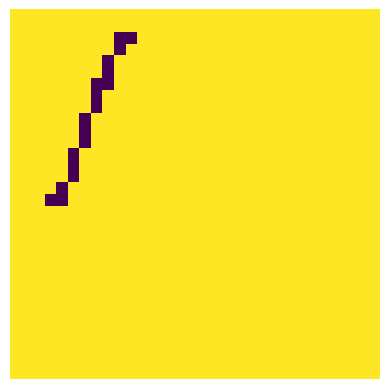

['triangle']
a triangle
1 t


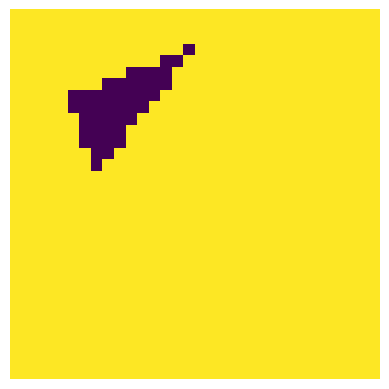

['triangle', 'circle', 'triangle']
a triangle and one circle and one triangle
1 t 1 c 1 t


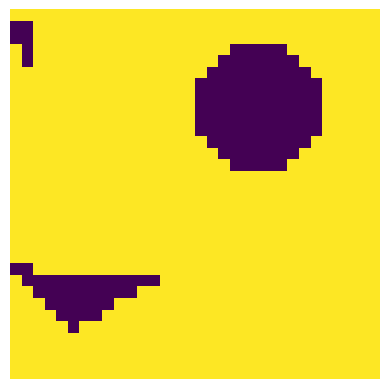

['circle', 'triangle']
triangle after circle
1 c 1 t


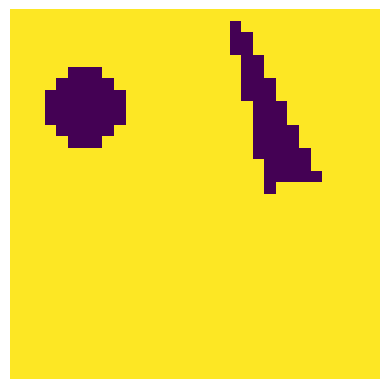

['triangle', 'circle', 'circle', 'circle']
a triangle and circle after circle and a circle
1 t 3 c


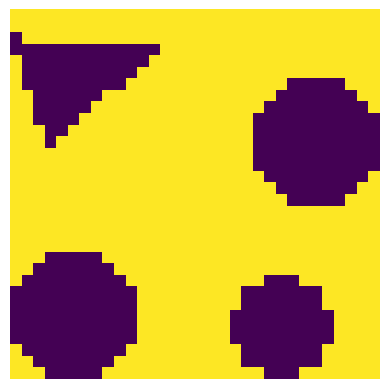

['triangle', 'circle', 'circle']
circle after triangle then one circle
1 t 2 c


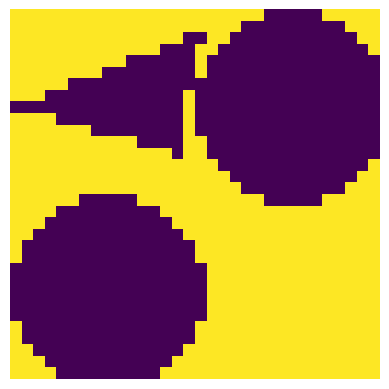

['triangle', 'triangle']
one triangle then a triangle
2 t


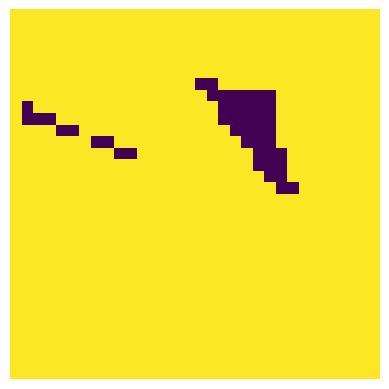

['triangle']
a triangle
1 t


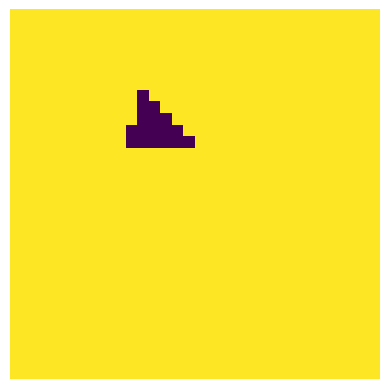

['triangle', 'circle', 'circle', 'circle']
a triangle and two circles
1 t 3 c


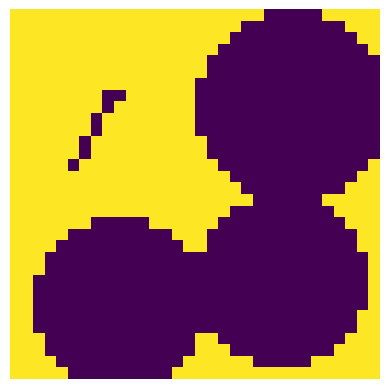

['circle', 'circle', 'triangle']
circle after circle and one triangle
2 c 1 t


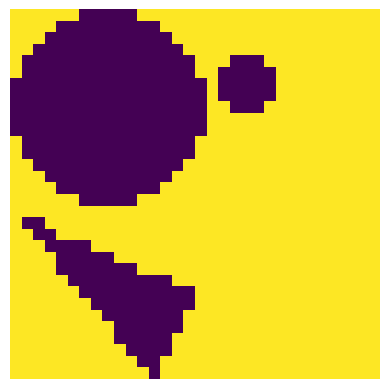

['circle', 'triangle']
triangle after circle
1 c 1 t


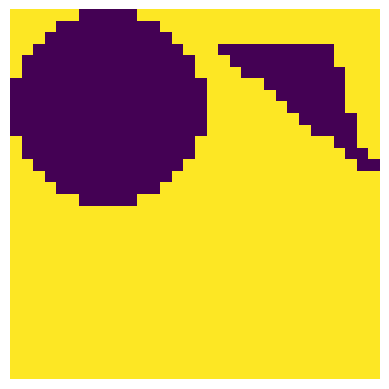

['circle']
a circle
1 c


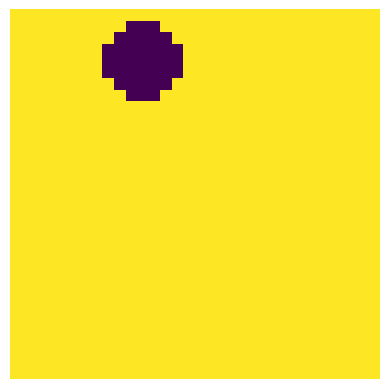

['circle', 'triangle', 'triangle', 'triangle']
triangle after circle then one triangle and one triangle
1 c 3 t


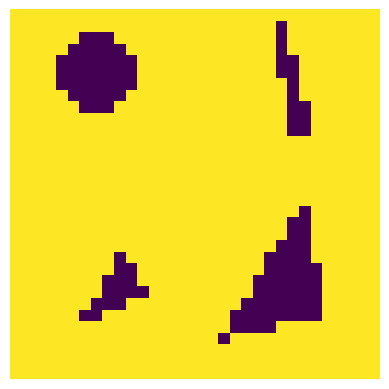

['circle', 'circle']
circle after circle
2 c


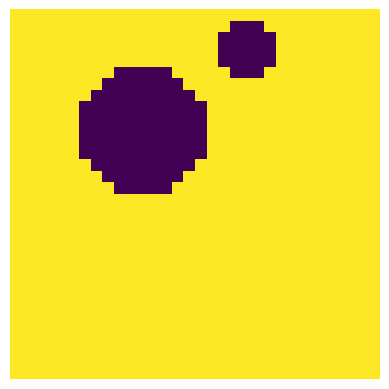

['circle', 'circle', 'triangle', 'triangle']
a circle and triangle after circle and a triangle
2 c 2 t


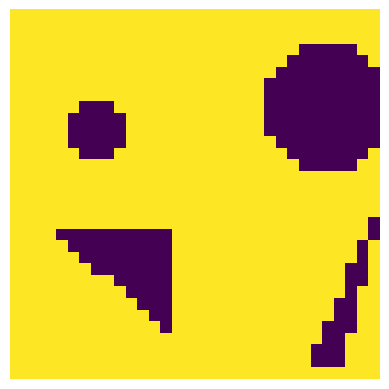

['triangle']
one triangle
1 t


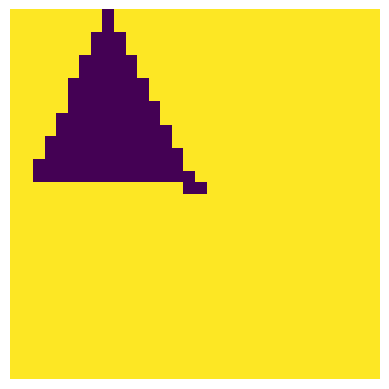

['circle']
one circle
1 c


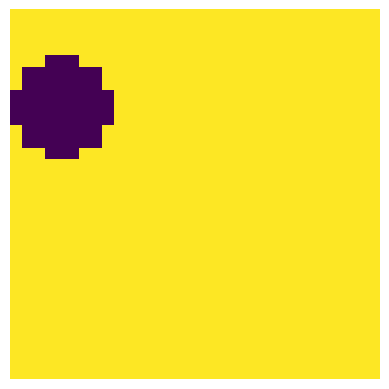

['circle', 'triangle', 'triangle', 'circle']
triangle after circle then circle after triangle
1 c 2 t 1 c


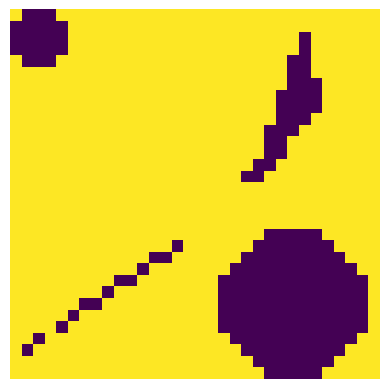

['circle', 'triangle', 'circle', 'triangle']
triangle after circle and a circle then one triangle
1 c 1 t 1 c 1 t


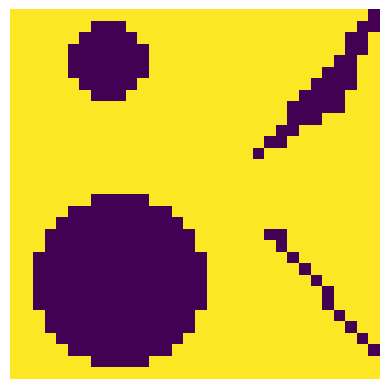

['circle']
one circle
1 c


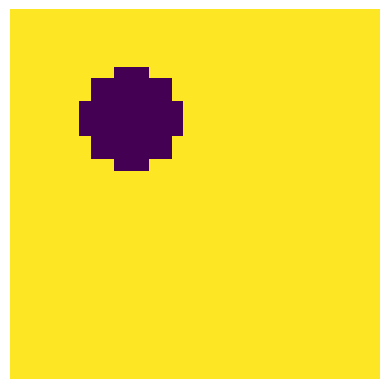

['circle']
a circle
1 c


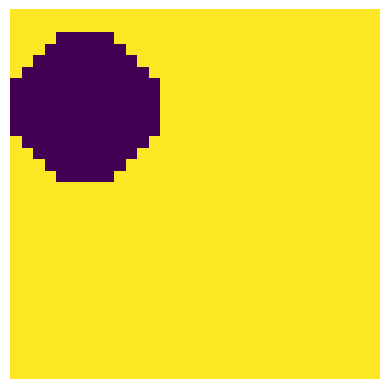

['circle', 'circle']
circle after circle
2 c


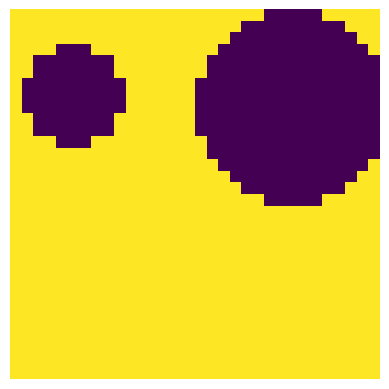

['circle', 'triangle']
a circle and one triangle
1 c 1 t


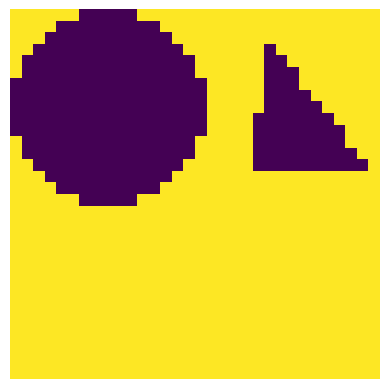

['circle', 'triangle', 'circle', 'triangle']
triangle after circle and one circle then one triangle
1 c 1 t 1 c 1 t


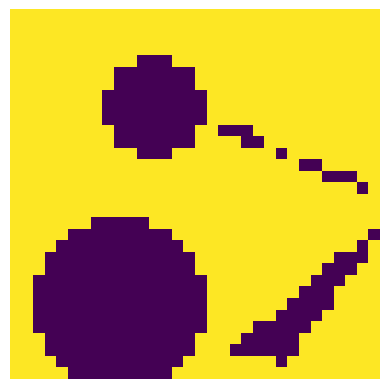

['circle', 'triangle', 'triangle']
one circle and triangle after triangle
1 c 2 t


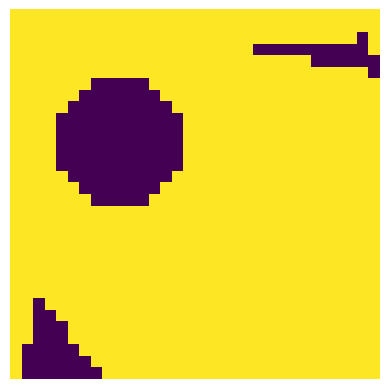

['triangle', 'circle', 'circle']
a triangle and one circle then a circle
1 t 2 c


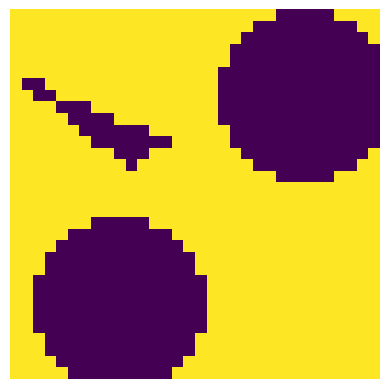

['triangle', 'triangle', 'circle']
triangle after triangle then one circle
2 t 1 c


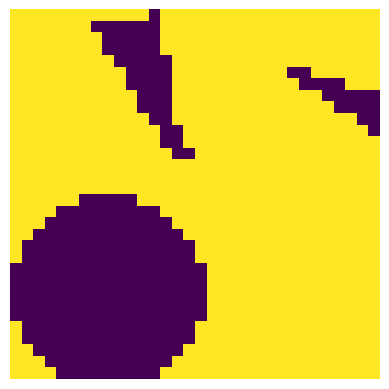

['circle', 'circle']
circle after circle
2 c


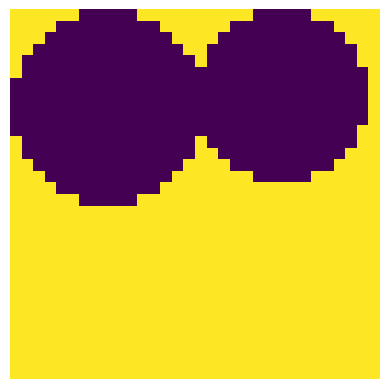

['triangle', 'circle', 'circle']
one triangle then one circle then one circle
1 t 2 c


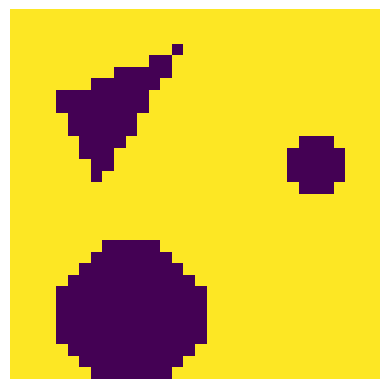

['triangle', 'triangle', 'triangle']
triangle after triangle and a triangle
3 t


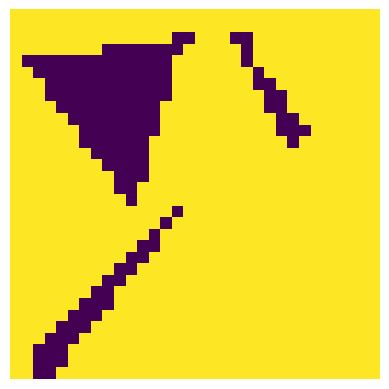

['circle']
a circle
1 c


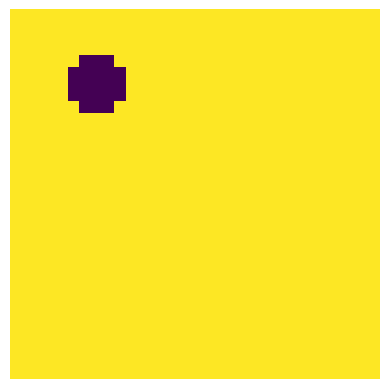

['circle', 'triangle', 'circle']
one circle and a triangle and one circle
1 c 1 t 1 c


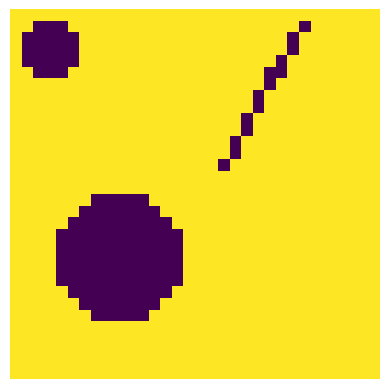

['triangle', 'circle']
circle after triangle
1 t 1 c


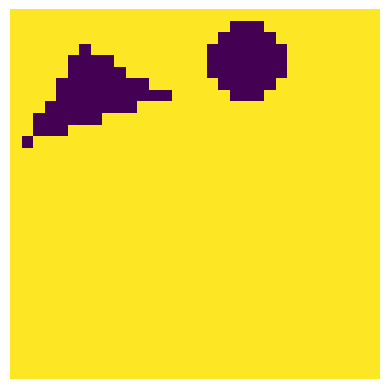

['circle']
one circle
1 c


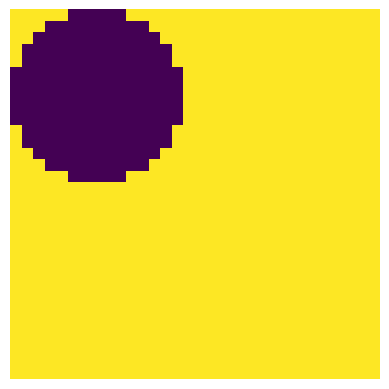

['triangle', 'triangle']
triangle after triangle
2 t


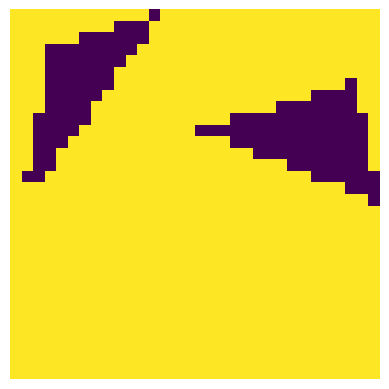

['circle', 'triangle', 'triangle']
one circle and two triangles
1 c 2 t


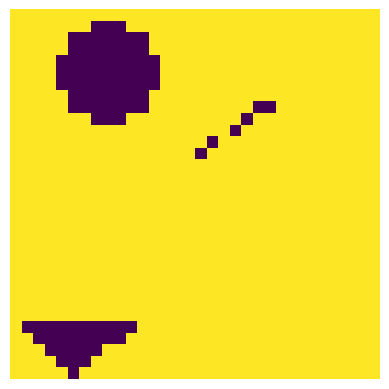

['triangle', 'triangle', 'circle']
two triangles
2 t 1 c


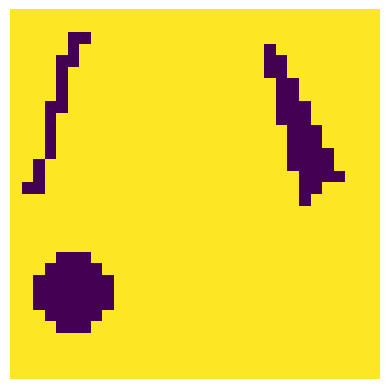

['triangle', 'circle', 'triangle', 'circle']
a triangle and one circle then one triangle and one circle
1 t 1 c 1 t 1 c


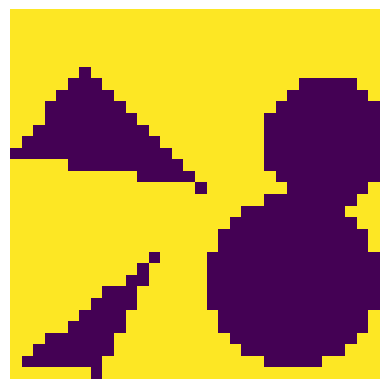

['triangle']
a triangle
1 t


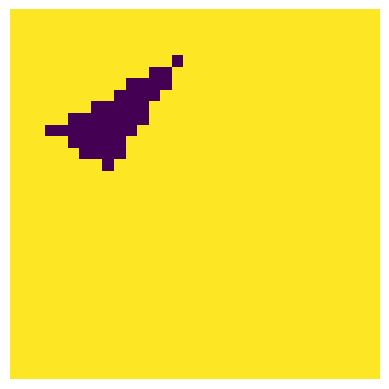

['triangle']
one triangle
1 t


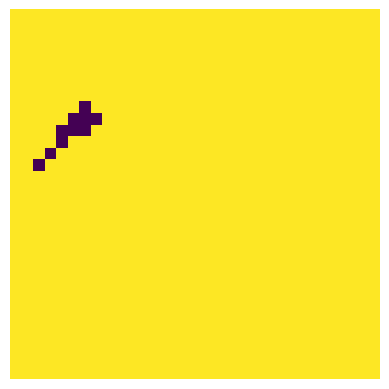

['triangle']
one triangle
1 t


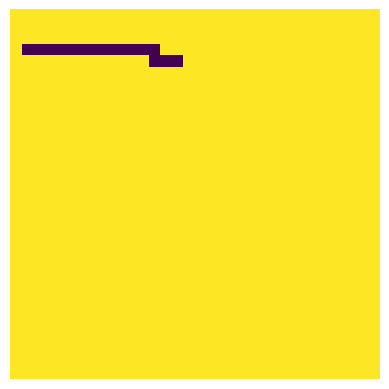

['triangle', 'circle', 'triangle', 'circle']
one triangle and a circle then circle after triangle
1 t 1 c 1 t 1 c


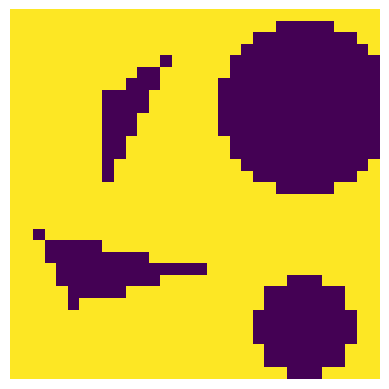

['triangle', 'triangle', 'triangle']
two triangles
3 t


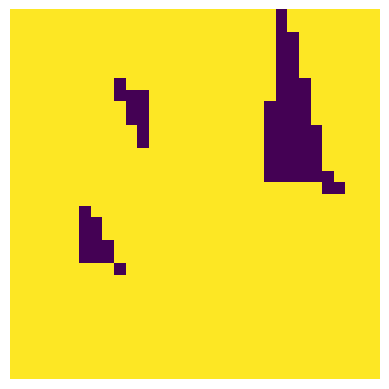

['triangle', 'circle']
circle after triangle
1 t 1 c


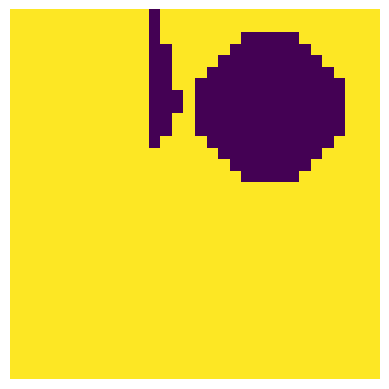

['circle', 'circle']
circle after circle
2 c


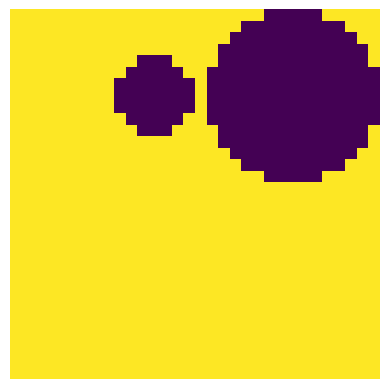

['triangle', 'triangle', 'triangle']
triangle after triangle then one triangle
3 t


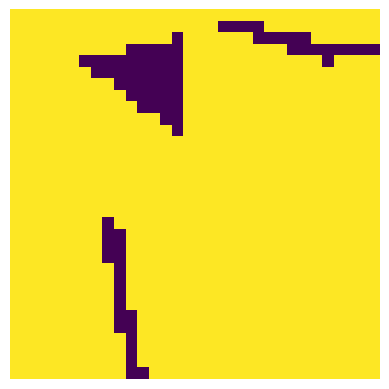

['circle', 'triangle', 'circle']
a circle then a triangle then a circle
1 c 1 t 1 c


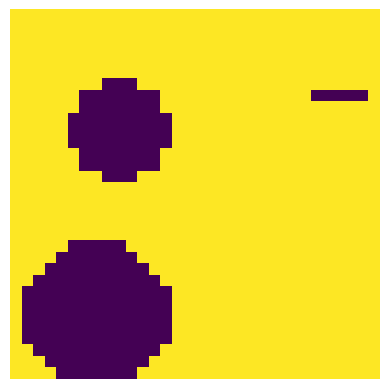

['circle', 'circle', 'triangle']
circle after circle and one triangle
2 c 1 t


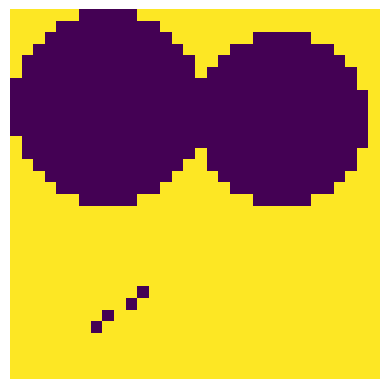

['circle', 'triangle']
triangle after circle
1 c 1 t


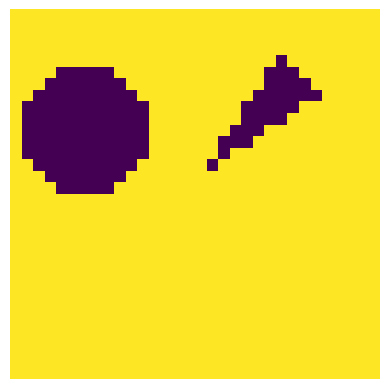

['circle', 'circle']
circle after circle
2 c


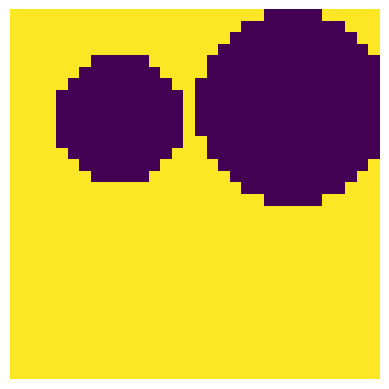

['triangle', 'circle', 'circle']
circle after triangle then one circle
1 t 2 c


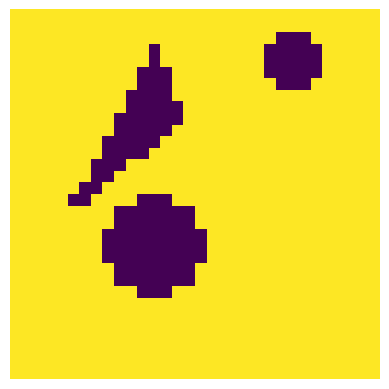

['triangle', 'triangle', 'circle']
one triangle then one triangle then a circle
2 t 1 c


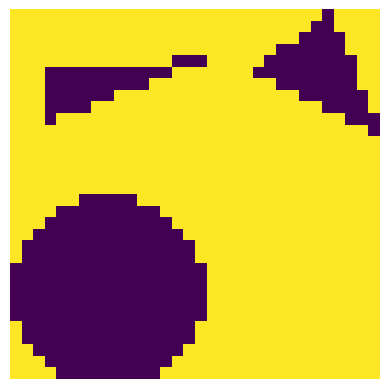

['triangle', 'circle', 'circle', 'triangle']
one triangle then circle after circle then a triangle
1 t 2 c 1 t


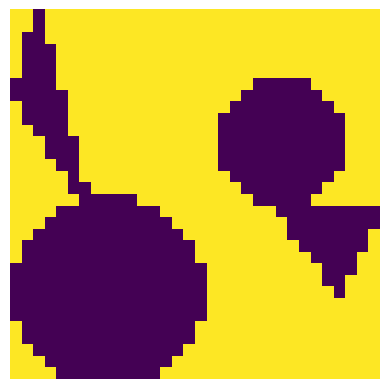

['triangle', 'circle', 'triangle']
circle after triangle and one triangle
1 t 1 c 1 t


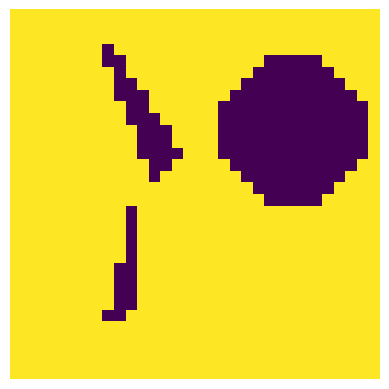

['circle', 'triangle', 'triangle']
triangle after circle then a triangle
1 c 2 t


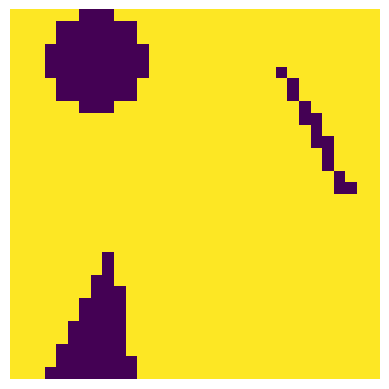

['triangle', 'triangle', 'circle', 'triangle']
triangle after triangle then triangle after circle
2 t 1 c 1 t


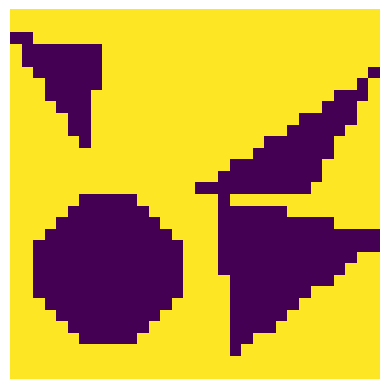

In [18]:
# Generate 100 random shape lists
shape_lists = [generate_random_shapes() for _ in range(100)]
code_lists = list(map(generate_code_str, shape_lists))
descriptions = []

# Generate descriptions and images for each shape list
for i, shape_list in enumerate(shape_lists):
  description = generate_descr_from_list(shape_list)
  descriptions.append(description)
  print(shape_list)
  print(description)
  print(code_lists[i])
  generate_image(shape_list, f"f{i}.png")
  plot_image(f"f{i}.png")


In [5]:
from torch.utils.data import Dataset


# Step 1: Prepare the Dataset
class CountingFiguresDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [6]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.8 MB/s eta 0:00:00


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import math
import torch.nn.functional as F
from einops import rearrange
from collections import OrderedDict
from easydict import EasyDict as edict

class MyTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary

    def encode_plus(self, text, add_special_tokens=True, max_length=MAX_LEN_SENTENCE, return_token_type_ids=False, padding='max_length', return_attention_mask=True, return_tensors='pt'):
        tokens = text.split()
        input_ids = [self.vocabulary.index(token) for token in tokens]
        attention_mask = [1] * len(input_ids)
        if add_special_tokens:
            input_ids = [self.vocabulary.index(CLASS_TOKEN)] + input_ids
            attention_mask += [1]
        if len(input_ids) > max_length:
            input_ids = input_ids[:max_length]
            attention_mask = attention_mask[:max_length]
        else:
            pad_length = max_length - len(input_ids)
            if pad_length >= 0:
                input_ids += [self.vocabulary.index(PAD_TOKEN)] * pad_length
                attention_mask += [0] * pad_length
        if return_attention_mask:
          return {
              'input_ids': torch.tensor(input_ids),
              'attention_mask': torch.tensor(attention_mask)
          }
        else:
          return {
              'input_ids': torch.tensor(input_ids)
          }


In [26]:
class MyAttention(nn.Module):
    def __init__(self, input_dim, hidden_key_dim, hidden_val_dim, enc_emb_dim=None, mask=False, num_heads=1):
        """
          Implements an attention mechanism

          Args:
          input_dim: Dimensionality of input embedding.
          hidden_key_dim: Dimensionality of key and query vectors.
          hidden_val_dim: Dimensionality of value vectors.
          enc_emb_dim: Dimensionality of encoder embeddings. If None, self-attention is used.
          mask: Whether to apply masking. If True, the attention scores for masked positions are set to -inf.
          num_heads: Number of attention heads.
        """
        super(MyAttention, self).__init__()
        self.input_dim = input_dim
        self.hidden_key_dim = hidden_key_dim
        self.hidden_val_dim = hidden_val_dim
        self.enc_emb_dim = enc_emb_dim
        self.num_heads = num_heads
        self.mask = mask

        if mask and enc_emb_dim is not None:
            raise ValueError("mask cannot be True if enc_emb_dim is provided")

        self.to_q = nn.Linear(self.input_dim, self.hidden_key_dim * self.num_heads, bias=False)

        for i in range(self.num_heads):
          if enc_emb_dim is None:
              self.to_k = nn.Linear(self.input_dim, self.hidden_key_dim * self.num_heads, bias=False)
              self.to_v = nn.Linear(self.input_dim, self.hidden_val_dim * self.num_heads, bias=False)
          else:
              self.to_k = nn.Linear(self.enc_emb_dim, self.hidden_key_dim * self.num_heads, bias=False)
              self.to_v = nn.Linear(self.enc_emb_dim, self.hidden_val_dim * self.num_heads, bias=False)

        self.to_out = nn.Linear(self.hidden_val_dim * self.num_heads, self.input_dim)

    def forward(self, embeddings, encoder_embeddings=None):

        if encoder_embeddings is None:
            Q = self.to_q(embeddings)
            K = self.to_k(embeddings)
            V = self.to_v(embeddings)
        else:
            Q = self.to_q(embeddings)
            K = self.to_k(encoder_embeddings)
            V = self.to_v(encoder_embeddings)

        Q = rearrange(Q, 'B T (H D) -> B H T D', H=self.num_heads, D=self.hidden_key_dim)
        K = rearrange(K, 'B T (H D) -> B H T D', H=self.num_heads, D=self.hidden_key_dim)
        V = rearrange(V, 'B T (H D) -> B H T D', H=self.num_heads, D=self.hidden_val_dim)

        scores = torch.einsum("BHTD,BHSD->BHTS", Q, K)

        if self.mask:
            mask_scores = torch.triu(torch.ones(scores.shape, dtype=torch.bool), diagonal=1).to(scores.device)
            print(mask_scores)
            scores = scores.masked_fill(mask_scores, float('-inf'))

        attnmats = F.softmax(scores / math.sqrt(self.hidden_key_dim), dim=-1)

        ctx_vecs = torch.einsum("BHTS,BHSD->BHTD", attnmats, V)
        ctx_vecs = rearrange(ctx_vecs, 'B H T D -> B T (H D)', H=self.num_heads, D=self.hidden_val_dim)
        return self.to_out(ctx_vecs)

In [12]:
class MyPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=MAX_LEN_SENTENCE):
        super(MyPositionalEncoding, self).__init__()

        # Create a matrix of shape (max_len, d_model) with all zeros
        pe = torch.zeros(max_len, d_model)

        # Create a column vector of shape (max_len, 1) with values [0, 1, ..., max_len-1]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Create a row vector of shape (1, d_model // 2) with values [0, 1, ..., d_model//2-1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices and cosine to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add a batch dimension (1, max_len, d_model) and register as buffer
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to the input tensor (B, T, D)
        x = x + self.pe[:, :x.size(1), :]
        return x

In [13]:
class MyTransformerEncoderLayer(nn.Module):
    def __init__(self, input_dim, hidden_key_dim, hidden_val_dim, output_dim, num_heads=1):
        super(MyTransformerEncoderLayer, self).__init__()
        self.input_dim = input_dim
        self.hidden_key_dim = hidden_key_dim
        self.hidden_val_dim = hidden_val_dim
        self.output_dim = output_dim
        self.num_heads = num_heads

        self.attention = MyAttention(self.input_dim, self.hidden_key_dim, self.hidden_val_dim, enc_emb_dim=None, mask=False, num_heads=self.num_heads)
        self.norm1 = nn.LayerNorm(self.input_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(self.input_dim, self.output_dim),
            nn.ReLU()
        )
        self.norm2 = nn.LayerNorm(self.output_dim)

    def forward(self, x):
        x = self.norm1(self.attention(x) + x)
        x = self.norm2(self.feed_forward(x) + x)
        return x

In [14]:
class MyTransformerEncoder(nn.Module):
    def __init__(self, num_tokens, input_dim, hidden_key_dim, hidden_val_dim, output_dim, max_length, num_layers=1, num_heads=1):
        super(MyTransformerEncoder, self).__init__()
        self.num_tokens = num_tokens
        self.input_dim = input_dim
        self.hidden_key_dim = hidden_key_dim
        self.hidden_val_dim = hidden_val_dim
        self.output_dim = output_dim
        self.max_length = max_length
        self.num_heads = num_heads

        self.embedding = nn.Embedding(num_tokens, self.input_dim)
        self.positional_encoding = MyPositionalEncoding(self.input_dim, max_length)
        self.layers = nn.ModuleList([MyTransformerEncoderLayer(self.input_dim, self.hidden_key_dim, self.hidden_val_dim, self.input_dim, num_heads) for _ in range(num_layers)])
        self.linear = nn.Linear(self.input_dim, self.output_dim)
        self.norm = nn.LayerNorm(self.output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x)
        x = self.linear(x)
        x = self.norm(x)
        return x

In [15]:
class MyTransformerClassifier(nn.Module):
    def __init__(self, transf_enc, num_classes):
        super(MyTransformerClassifier, self).__init__()
        self.num_classes = num_classes
        self.transf_enc = transf_enc

        self.linear = nn.Linear(self.transf_enc.output_dim, self.num_classes)

    def forward(self, input_ids, labels=None, attention_mask=None):
        x = self.transf_enc(input_ids)[:, 0, :] # Just the embedding of the first token, which is the CLS token.
        logits = self.linear(x)

        loss = None
        if labels is not None:
            criterion = nn.CrossEntropyLoss()
            loss = criterion(logits, labels)
        return (loss, logits) if loss is not None else logits

In [16]:
import torch
from transformers import Trainer, TrainingArguments
import pandas as pd

# Step 2: Tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = MyTokenizer(VOCABULARY)
tokenizer.encode_plus(
            "one circle after one circle and two triangles",
            add_special_tokens=True,
            max_length=MAX_LEN_SENTENCE,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

{'input_ids': tensor([10,  5,  1,  8,  5,  1,  6,  9,  2, 13, 13, 13, 13, 13, 13, 13]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])}

In [28]:
# Create Dataset
lengths = list(map(len, shape_lists))
dataset = CountingFiguresDataset(descriptions, lengths, tokenizer, max_length=MAX_LEN_SENTENCE)

In [29]:
num_tokens = len(VOCABULARY)
input_dim = 16
hidden_key_dim = 8
hidden_val_dim = 8
num_heads = 2
output_dim = 16
num_layers = 3
num_labels = 5

# Step 3: Model
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10)
transf_enc = MyTransformerEncoder(num_tokens, input_dim=input_dim, hidden_key_dim=hidden_key_dim, hidden_val_dim=hidden_val_dim, output_dim=output_dim, max_length=MAX_LEN_SENTENCE, num_layers=num_layers, num_heads=num_heads)
model = MyTransformerClassifier(transf_enc, num_labels)
# model = DummyClassifier(num_labels)

# Step 4: Training
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=200,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=10,
    weight_decay=0.001,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch"
)

# Split dataset into train and eval
train_size = int(0.8 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size])

# Custom Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

trainer.train()



Epoch,Training Loss,Validation Loss
1,2.024500,2.442374
2,2.232200,2.351706
3,1.972000,2.249130
4,1.877200,2.146125
5,2.034400,2.039893
6,1.745900,1.936911
7,1.754700,1.836697
8,1.656600,1.759796
9,1.561700,1.692223
10,1.536700,1.651401


TrainOutput(global_step=8000, training_loss=0.9195697856843471, metrics={'train_runtime': 135.406, 'train_samples_per_second': 118.163, 'train_steps_per_second': 59.082, 'total_flos': 0.0, 'train_loss': 0.9195697856843471, 'epoch': 200.0})

In [30]:
from torch.utils.data import DataLoader

# Step 5: Evaluation
def evaluate_model(texts, labels):
    eval_dataset = CountingFiguresDataset(texts, labels, tokenizer, max_length=MAX_LEN_SENTENCE)
    eval_loader = DataLoader(eval_dataset, batch_size=2)
    total_correct = 0
    total_samples = len(labels)
    model.eval()
    with torch.no_grad():
        for batch in eval_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=-1)
            total_correct += (preds == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Accuracy: {accuracy * 100:.2f}%')


# Generate descriptions and images for each shape list

test_shape_lists = [generate_random_shapes() for _ in range(100)]

eval_descriptions = []
eval_lengths = []
for i, shape_list in enumerate(test_shape_lists):
  eval_descriptions.append(generate_descr_from_list(shape_list))
  eval_lengths.append(len(shape_list))

evaluate_model(eval_descriptions, eval_lengths)

Accuracy: 67.00%


In [33]:
class MyTransformerDecoderLayer(nn.Module):
    def __init__(self, input_dim, hidden_key_dim, hidden_val_dim, output_dim, enc_emb_dim, num_heads):
        super(MyTransformerEncoderLayer, self).__init__()
        self.input_dim = input_dim
        self.hidden_key_dim = hidden_key_dim
        self.hidden_val_dim = hidden_val_dim
        self.output_dim = output_dim
        self.enc_emb_dim = enc_emb_dim
        self.num_heads = num_heads

        self.masked_att = MyAttention(self.input_dim, self.hidden_key_dim, self.hidden_val_dim, enc_emb_dim=None, mask=True, num_heads=self.num_heads)
        self.norm1 = nn.LayerNorm(self.input_dim)
        self.cross_att = MyAttention(self.input_dim, self.hidden_key_dim, self.hidden_val_dim, enc_emb_dim=self.enc_emb_dim, mask=False, num_heads=self.num_heads)
        self.norm2 = nn.LayerNorm(self.input_dim)
        self.self_att = MyAttention(self.input_dim, self.hidden_key_dim, self.hidden_val_dim, enc_emb_dim=None, mask=False, num_heads=self.num_heads)
        self.norm3 = nn.LayerNorm(self.input_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.ReLU()
        )

    def forward(self, x, enc_emb):
        x = self.norm1(x + self.masked_att(x))
        x = self.norm2(x + self.cross_att(x, enc_emb))
        x = self.norm3(x + self.self_att(x))
        x = self.feed_forward(x)
        return x

In [34]:
class MyTransformerDecoder(nn.Module):
    def __init__(self, num_tokens, input_dim, hidden_key_dim, hidden_val_dim, output_dim, enc_emb_dim, max_length, num_layers, num_heads):
        super(MyTransformerEncoder, self).__init__()
        self.num_tokens = num_tokens
        self.input_dim = input_dim
        self.hidden_key_dim = hidden_key_dim
        self.hidden_val_dim = hidden_val_dim
        self.output_dim = output_dim
        self.enc_emb_dim = enc_emb_dim
        self.max_length = max_length
        self.num_heads = num_heads

        self.embedding = nn.Embedding(num_tokens, self.input_dim)
        self.positional_encoding = MyPositionalEncoding(self.input_dim, max_length)
        self.layers = nn.ModuleList([MyTransformerDecoderLayer(input_dim=self.input_dim,
                                                               hidden_dim=self.hidden_dim,
                                                               enc_emb_dim=self.enc_emb_dim,
                                                               num_heads=num_heads) for _ in range(num_layers)])
        self.linear = nn.Linear(self.input_dim, self.output_dim)
        self.norm = nn.LayerNorm(self.output_dim)

    def forward(self, x, enc_emb):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, enc_emb)
        x = self.linear(x)
        x = self.norm(x)
        return x

In [35]:
class MyTransformerTranslator(nn.Module):
    def __init__(self, transf_enc, transf_dec, source_tokenizer, target_tokenizer):
        super(MyTransformerTranslator, self).__init__()
        self.transf_enc = transf_enc
        self.transf_dec = transf_dec
        self.source_tokenizer = source_tokenizer
        self.target_tokenizer = target_tokenizer
        self.target_vocabulary_size = len(target_tokenizer.vocabulary)

    def forward(self, source_embeddings, target_embeddings):
        source_embeddings = self.transf_enc(source_embeddings)
        decoded_embeddings = self.transf_dec(target_embeddings, source_embeddings)
        return decoded_embeddings